In [437]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
import seaborn as sbn
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
warnings.filterwarnings('ignore')

# 데이터 로드 및 전처리

In [438]:
train=pd.read_csv('C:/Users/korea/Downloads/보안/train.csv')
test=pd.read_csv('C:/Users/korea/Downloads/보안/test.csv')
submission=pd.read_csv('C:/Users/korea/Downloads/보안/sample_submission.csv')
val=pd.read_csv('C:/Users/korea/Downloads/보안/validation_sample.csv')

In [428]:
#train level별 값 확인
train['level'].value_counts()

0    334065
1    132517
3      4141
5      2219
2        12
4        10
6         8
Name: level, dtype: int64

In [429]:
train

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...
...,...,...,...
472967,472967,0,Feb 28 10:10:06 localhost logstash: 7738 error:
472968,472968,1,type=SYSCALL msg=audit(1611890993.458:321827):...
472969,472969,0,"Oct 12 02:20:29 localhost kibana: {""type"":""log..."
472970,472970,0,"Jan 15 09:02:43 localhost kibana: {""type"":""err..."


In [439]:
# 데이터 마스킹

# 월,일 형식은 -> <MONTHDAYTIME>으로 변경
train['full_log'] = train['full_log'].str.replace(r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) (?:[0-9]| [0-9]|[1-3][0-9]) (?:[01][0-9]|2[0-3])[:h][0-5][0-9][:m][0-5][0-9]', 'MONTHDAYTIME')

# 날짜 형식은 -> <DATETIME>으로 변경
train['full_log'] = train['full_log'].str.replace(r'\d{4}\-\d{2}\-\d{2}T(?:[01][0-9]|2[0-3])[:h][0-5][0-9][:m][0-5][0-9]', 'DATETIME')

# 시간 형식은 -> <TIME>으로 변경
train['full_log'] = train['full_log'].str.replace(r'(?:[01][0-9]|2[0-3])[:h][0-5][0-9][:m][0-5][0-9]', 'TIME')
train['full_log'] = train['full_log'].str.replace(r'(?:[01][0-9]|2[0-3])[:h][0-5][0-9]', 'TIME')

# IP 주소 형식은 -> <IPADDRESS>로 변경
train['full_log'] = train['full_log'].str.replace(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+', 'IPADDRESS')
train['full_log'] = train['full_log'].str.replace(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', 'IPADDRESS')

# 포트 형식은 -> <PORT>로 변경
train['full_log'] = train['full_log'].str.replace(r'port \d+', 'PORT')

# 한글 형식은 -> <KOREAN>로 변경, 숫자 형식은 -> <NUM>으로 변경
train['full_log'] = train['full_log'].str.replace(r'[ㄱ-ㅣ가-힣]+', 'KOREAN').str.replace(r'[0-9]+', 'NUM')

# 특수문자 공백으로 변경
train['full_log'] = train['full_log'].str.replace(r'[^a-zA-Z<>]', ' ')

# 영어 소문자로 변경
train['full_log'] = train['full_log'].str.lower()

In [441]:
# 중복제거

# log가 같은데도 다른 level 가지는 값들 추출
def count_level(df):
    columns = df.columns
    count = 0
    for col in columns:
        count += (df[col] > 0)
    return count

pivot = train.pivot_table(values='id', index='full_log', columns='level', aggfunc='count', fill_value=0)
pivot['count'] = count_level(pivot)
pivot[pivot['count'] > 1]

# 빈도수가 가장 높은 level로 설정
dupl = pivot[pivot['count'] > 1].copy()
dupl['level'] = np.argmax(dupl.iloc[:, :-1].values, axis=-1)
dupl

level,0,1,2,3,4,5,6,count,level
full_log,,,,,,,,,
juniper,4,0,0,1,0,0,0,2,0
level rule level log log,10,8,0,0,0,0,0,2,0
level num log commit at was successful,1,1,0,0,0,0,0,2,0
level num log lsys logical system name attack name message ip address zone name source zone name interface name interface name action action,1,1,0,0,0,0,0,2,0
level num log abort executable name pid version version built by builder on date error message,1,1,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...
level num log versions of rpd and librpd did not match not retrying,1,1,0,0,0,0,0,2,0
level num log vpn vpn name from remote address is down,2,1,0,0,0,0,0,2,0
level num log vpn vpn name from remote address is up,1,1,0,0,0,0,0,2,0


In [442]:
# 빈도수가 가장 높은 level이 아닌 값들 제거
for index in dupl.index:
    targets = train[(train['full_log']==index) & (train['level']!=dupl['level'][index])].index
    train.drop(index=targets, inplace=True)
    
print(train.shape)
train['level'].value_counts()

(472549, 3)


0    334020
1    132181
3      4139
5      2180
2        11
4        10
6         8
Name: level, dtype: int64

In [443]:
#train['full_log'] => train_text로 list
#train['level']=> train_level로 array
train_text=list(train['full_log'])
train_level=np.array(train['level'])

In [444]:
# 자연어 처리

# Countvector를 활용한 수치화
vectorizer=CountVectorizer(analyzer="word", max_features=10000)
train_features_count=vectorizer.fit_transform(train_text)

# TF-IDF를 활용한 수치화
vectorizer1=TfidfVectorizer(analyzer="word", max_features=10000)
train_features_tfidf=vectorizer1.fit_transform(train_text)

# 데이터 확인

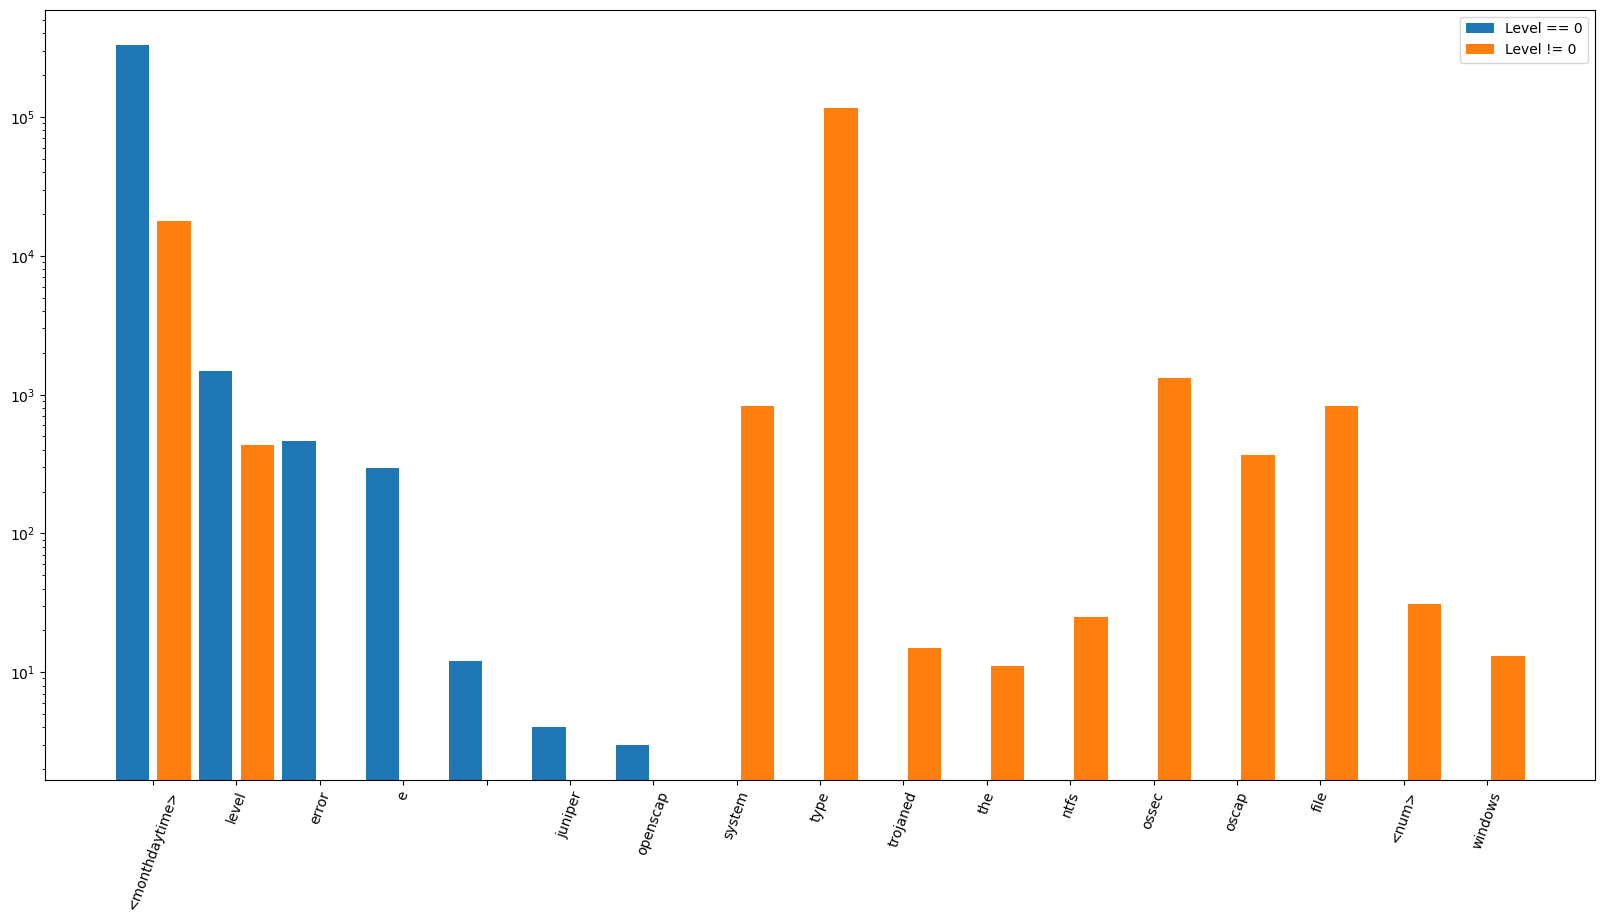

In [159]:
# 첫번째 단어 추출
first_strings = pd.merge(
    
    train.loc[train.level!=0].full_log.apply(lambda x: x.split(' ')[0]).value_counts().rename('lv!=0'),
    train.loc[train.level==0].full_log.apply(lambda x: x.split(' ')[0]).value_counts().rename('lv==0'),
    'outer',left_index=True,right_index=True).fillna(0).astype(int)
first_strings = first_strings.sort_values('lv==0',ascending=False)

# 첫번째 단어에 따른 level 분류
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.bar([i-0.25 for i in range(first_strings.shape[0])],first_strings.values[:,1],width=0.4)
ax.bar([i+0.25 for i in range(first_strings.shape[0])],first_strings.values[:,0],width=0.4)
ax.set_yscale("log")
ax.set_xticks(range(first_strings.shape[0]))
ax.set_xticklabels(first_strings.index,rotation=70)
ax.legend(['Level == 0','Level != 0'])
fig.show()

In [154]:
first_strings

,lv!=0,lv==0
<monthdaytime>,17804,331771
level,436,1474
error,0,459
e,0,297
,0,12
juniper,0,4
openscap,0,3
system,820,0
type,116868,0
trojaned,15,0


## 위험도가 0일 때 첫단어가 99% monthdaytime이고  
## 위험도가 0이 아닐 때 첫단어가 84% type 임

In [155]:
# Count 상위 50개의 값

feature_names = vectorizer.get_feature_names_out()
sum_words = train_features_count.sum(axis=0)
word_counts = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_counts.sort(key=lambda x: x[1], reverse=True)

top_n = 50
print("빈도수 TOP50 :")
for word, count in word_counts[:top_n]:
    print(f"{word}: {count}")

빈도수 TOP50 :
num: 9110779
error: 838990
type: 742210
audit: 622331
msg: 502170
elasticsearch: 449372
localhost: 429812
kibana: 423669
no: 408787
connections: 390508
living: 376626
cap: 361842
at: 355148
js: 354705
monthdaytime: 352360
usr: 323531
message: 301020
logstash: 288333
pid: 287611
system: 272694
time: 261143
datetime: 260003
lib: 252068
modules: 243902
name: 239986
node: 236933
to: 234307
share: 233808
syscall: 233679
src: 233422
proctitle: 232372
cwd: 232188
process: 228806
next: 226357
bin: 224908
connection: 217010
unconfined: 202264
pool: 185931
timestamp: 176885
fd: 174411
tags: 170189
ossec: 154387
syscheckd: 149400
path: 139024
object: 134696
dev: 134479
mode: 134288
inode: 134255
item: 134202
ouid: 134197


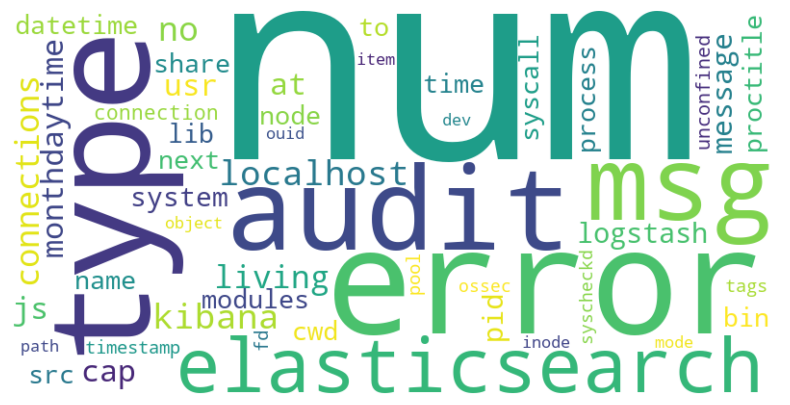

In [291]:
# count 상위 50 시각화

def generate_wordcloud(word_counts):
    # word_counts: (word, count) 쌍의 리스트

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_counts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
generate_wordcloud(word_counts[:top_n])

In [298]:
# TF-IDF 상위 50개의 값
feature_names = vectorizer.get_feature_names_out()
sum_scores = train_features_tfidf.sum(axis=0)
word_scores = [(word, sum_scores[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_scores.sort(key=lambda x: x[1], reverse=True)

top_n = 50
print("TF-IDF 상위 50개 단어:")
for word, score in word_scores[:top_n]:
    print(f"{word}: {score}")

TF-IDF 상위 50개 단어:
num: 167984.82259802462
error: 64302.270075078035
logstash: 38453.32383568678
kibana: 36894.18793546003
no: 35430.97339828499
connections: 34553.197487647725
elasticsearch: 34465.99253341857
living: 33504.737170462984
localhost: 33191.045967134014
js: 32578.479624124615
at: 32544.08303069372
monthdaytime: 28521.99263300815
to: 25942.30195998653
message: 25419.749253363974
type: 23748.989146029548
node: 21642.245904775027
share: 21622.542361451207
src: 21531.21800050569
process: 21522.85738584457
next: 21476.246448901817
modules: 21337.861413857245
lib: 20585.05543253539
audit: 20063.443485085223
datetime: 19822.678246927175
usr: 19041.398417710396
connection: 18505.03117838356
timestamp: 17734.059633638233
tags: 17560.671327532906
outputs: 16649.589809351226
msg: 16159.360929961222
pid: 15447.263522877965
korean: 15352.170086272945
pool: 15328.384671570357
failed: 14212.345952816022
for: 14173.10404571988
http: 14084.696082145565
log: 14059.13229429412
task: 13292.751

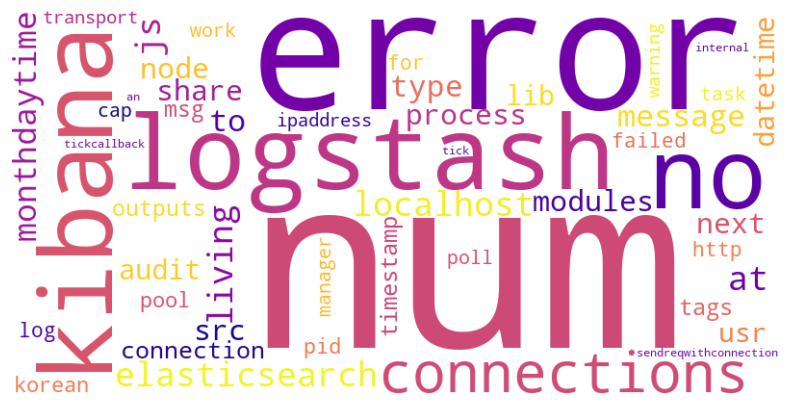

In [334]:
# TF-IDF 상위 50개의 wordcloud
def generate_wordcloud(word_scores):
    # word_scores: (word, score) 쌍의 리스트

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate_from_frequencies(dict(word_scores))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
generate_wordcloud(word_scores[:top_n])

# XGBOOST를 활용한 보안 위험도 예측 (CountVectorizer)

In [254]:
# train, validation set 구분
train_level=np.array(train['level'])

x_train, x_valid, y_train, y_valid = train_test_split(train_features_count, train_level, test_size=0.2, stratify=train_level, random_state = 123)

In [255]:
# XGBClassifier

xgb_clf = XGBClassifier(booster='gbtree', 
                    colsample_bylevel=0.8, 
                    colsample_bytree=0.7, 
                    gamma=0, 
                    max_depth=5, learning_rate=0.15,
                    n_estimators=100, 
                    nthread=4,
                    objective = 'multi:softmax',
                    silent= False,
                    random_state = 1234)

xgb_clf.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],
             early_stopping_rounds=10)
xgb_clf.score(x_valid, y_valid)

[15:15:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-mlogloss:1.51330
[1]	validation_0-mlogloss:1.20016
[2]	validation_0-mlogloss:0.98153
[3]	validation_0-mlogloss:0.81555
[4]	validation_0-mlogloss:0.68445
[5]	validation_0-mlogloss:0.57814
[6]	validation_0-mlogloss:0.49073
[7]	validation_0-mlogloss:0.41803
[8]	validation_0-mlogloss:0.35700
[9]	validation_0-mlogloss:0.30545
[10]	validation_0-mlogloss:0.26190
[11]	validation_0-mlogloss:0.22480
[12]	validation_0-mlogloss:0.19337
[13]	validation_0-mlogloss:0.16649
[14]	validation_0-mlogloss:0.14340
[15]	validation_0-mlogloss:0.12375
[16]	validation_0-mlogloss:0.10681
[17]	validation_0-mlogloss:0.09229
[18]	validation_0-mlogloss:0.07980
[19]	validation_0-mlogloss:0.06911
[20]	validation_0-mlogloss:0.05991
[21]	validation_0-mlogloss:0.05199
[22]	validation_0-mlogloss:0.04520
[23]	vali

0.9990159875570039

In [256]:
#crosstab으로 확인
pred = xgb_clf.predict(x_valid)
crosstab = pd.crosstab(y_valid, pred, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,2,3,4,5,6
real,,,,,,,
0,66799,4,0,1,0,0,0
1,80,26356,0,0,0,0,0
2,0,0,2,0,0,0,0
3,2,0,0,826,0,0,0
4,0,0,0,0,2,0,0
5,5,0,0,0,0,431,0
6,0,0,0,0,0,0,2
7,0,0,0,0,0,1,0


In [257]:
metrics.f1_score(y_valid, pred, average='macro')

0.8736244599980336

In [258]:
probas=xgb_clf.predict_proba(x_valid)
print(pred.shape)
print(probas.shape)

(94511,)
(94511, 8)


In [259]:
pd.DataFrame(probas)

,0,1,2,3,4,5,6,7
0,0.000001,0.999993,6.954102e-07,1.610351e-06,3.961886e-07,0.000002,5.598115e-07,8.417626e-07
1,0.999989,0.000004,9.802008e-07,2.014561e-06,5.260586e-07,0.000002,1.144668e-06,1.478232e-06
2,0.999991,0.000003,6.209954e-07,7.164962e-07,4.071613e-07,0.000002,1.194407e-06,1.364303e-06
3,0.999989,0.000004,9.802008e-07,2.014561e-06,5.260586e-07,0.000002,1.144668e-06,1.478232e-06
4,0.000001,0.999992,6.954094e-07,2.427954e-06,3.961881e-07,0.000002,5.224434e-07,1.155895e-06
...,...,...,...,...,...,...,...,...
94506,0.999992,0.000003,4.049657e-07,8.756139e-07,5.270120e-07,0.000002,1.045163e-06,4.870816e-07
94507,0.000002,0.999985,1.322888e-06,3.147937e-06,7.536739e-07,0.000004,9.938501e-07,1.735221e-06
94508,0.999991,0.000003,6.209954e-07,7.164962e-07,4.071613e-07,0.000002,1.194407e-06,1.364303e-06
94509,0.999990,0.000003,6.075940e-07,8.324442e-07,3.983745e-07,0.000002,1.039055e-06,1.734920e-06


# 새로운 유형의 위험도 7설정 (CountVectorizer)

In [219]:
# 각 행에서 가장 높은 확률을 뽑아 10분위 파악 
l=[]
l2=list(np.argmax(probas,axis=1))
for i in range(len(probas)):
    l.append(probas[i][l2[i]])
print(np.percentile(l,[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))

[0.458929   0.69003689 0.7861315  0.80437409 0.85910675 0.97095
 0.99425101 0.99548858 0.99590061 0.99689519 0.99736426]


In [220]:
# threshold 설정 및 분류
pred[np.where(np.max(probas, axis=1)<0.69003689)]=7
new_crosstab = pd.crosstab(y_valid, pred, rownames=['real'], colnames=['pred'])
new_crosstab

pred,0,1,2,3,4,5,6,7
real,,,,,,,,
0,33233,0,0,0,0,0,0,169
1,0,13176,0,0,0,0,0,42
2,0,0,1,0,0,0,0,0
3,0,0,0,412,0,0,0,2
4,0,0,0,0,1,0,0,0
5,0,0,0,0,0,215,0,3
6,0,0,0,0,0,0,1,0


# XGBOOST를 활용한 보안 위험도 예측 (TF-IDF)

In [445]:
# train, validation set 구분
train_level=np.array(train['level'])

x_train, x_valid, y_train, y_valid = train_test_split(train_features_tfidf, train_level, test_size=0.3, stratify=train_level, random_state = 1234)

In [446]:
# XGBClassifier

xgb_clf = XGBClassifier(booster='gbtree', 
                    colsample_bylevel=0.8, 
                    colsample_bytree=0.7, 
                    gamma=0, 
                    max_depth=5, learning_rate=0.15,
                    n_estimators=100, 
                    nthread=4,
                    objective = 'multi:softmax',
                    silent= False,
                    random_state = 1234)

xgb_clf.fit(x_train, y_train, eval_set=[(x_valid, y_valid)],
             early_stopping_rounds=10)
xgb_clf.score(x_valid, y_valid)

[18:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-mlogloss:1.44944
[1]	validation_0-mlogloss:1.15646
[2]	validation_0-mlogloss:0.94818
[3]	validation_0-mlogloss:0.78873
[4]	validation_0-mlogloss:0.66244
[5]	validation_0-mlogloss:0.55979
[6]	validation_0-mlogloss:0.47508
[7]	validation_0-mlogloss:0.40460
[8]	validation_0-mlogloss:0.34550
[9]	validation_0-mlogloss:0.29554
[10]	validation_0-mlogloss:0.25327
[11]	validation_0-mlogloss:0.21746
[12]	validation_0-mlogloss:0.18692
[13]	validation_0-mlogloss:0.16082
[14]	validation_0-mlogloss:0.13851
[15]	validation_0-mlogloss:0.11940
[16]	validation_0-mlogloss:0.10305
[17]	validation_0-mlogloss:0.08902
[18]	validation_0-mlogloss:0.07696
[19]	validation_0-mlogloss:0.06662
[20]	validation_0-mlogloss:0.05773
[21]	validation_0-mlogloss:0.05009
[22]	validation_0-mlogloss:0.04355
[23]	vali

0.9990406658907347

In [447]:
#crosstab으로 확인
pred = xgb_clf.predict(x_valid)
crosstab = pd.crosstab(y_valid, pred, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,2,3,4,5,6
real,,,,,,,
0,100198,7,0,0,0,1,0
1,112,39542,0,0,0,0,0
2,0,0,3,0,0,0,0
3,6,0,0,1236,0,0,0
4,0,0,0,0,3,0,0
5,10,0,0,0,0,644,0
6,0,0,0,0,0,0,3


In [448]:
metrics.f1_score(y_valid, pred, average='macro')

0.9981328536866424

In [449]:
probas=xgb_clf.predict_proba(x_valid)
print(pred.shape)
print(probas.shape)

(141765,)
(141765, 7)


In [450]:
pd.DataFrame(probas)

,0,1,2,3,4,5,6
0,0.999982,0.000009,1.276272e-06,0.000002,1.090767e-06,0.000002,1.783797e-06
1,0.999977,0.000010,1.179462e-06,0.000002,3.720673e-06,0.000002,3.619043e-06
2,0.999987,0.000006,7.151812e-07,0.000002,1.458789e-06,0.000002,1.703605e-06
3,0.000008,0.999984,1.299979e-06,0.000002,9.660143e-07,0.000003,9.831715e-07
4,0.999983,0.000009,2.000528e-06,0.000002,7.096037e-07,0.000002,9.628410e-07
...,...,...,...,...,...,...,...
141760,0.999889,0.000056,3.350547e-06,0.000019,5.065436e-06,0.000022,5.538238e-06
141761,0.999982,0.000009,1.276272e-06,0.000002,1.090767e-06,0.000002,1.783797e-06
141762,0.000008,0.999985,1.316415e-06,0.000002,8.915998e-07,0.000003,9.074353e-07
141763,0.000008,0.999980,1.426281e-06,0.000002,9.660108e-07,0.000006,1.981751e-06


# 새로운 유형의 위험도 7설정 (TF-IDF)

In [451]:
# 각 행에서 가장 높은 확률을 뽑아 10분위 파악 
l=[]
l2=list(np.argmax(probas,axis=1))
for i in range(len(probas)):
    l.append(probas[i][l2[i]])
print(np.percentile(l,[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))

[0.44677863 0.76390559 0.81371308 0.86317408 0.94495631 0.99026066
 0.99367023 0.99632907 0.9973653  0.99802738 0.99831867]


In [453]:
# threshold 설정 및 분류 (하위 10%)
pred[np.where(np.max(probas, axis=1)<0.76390559)]=7
new_crosstab = pd.crosstab(y_valid, pred, rownames=['real'], colnames=['pred'])
new_crosstab

pred,0,1,2,3,4,5,6,7
real,,,,,,,,
0,100119,1,0,0,0,0,0,86
1,74,39526,0,0,0,0,0,54
2,0,0,3,0,0,0,0,0
3,4,0,0,1236,0,0,0,2
4,0,0,0,0,3,0,0,0
5,10,0,0,0,0,644,0,0
6,0,0,0,0,0,0,3,0


# TEST 

In [455]:

# 월,일 형식은 -> <MONTHDAYTIME>으로 변경
test['full_log'] = test['full_log'].str.replace(r'(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) (?:[0-9]| [0-9]|[1-3][0-9]) (?:[01][0-9]|2[0-3])[:h][0-5][0-9][:m][0-5][0-9]', '<MONTHDAYTIME>')

# 날짜 형식은 -> <DATETIME>으로 변경
test['full_log'] = test['full_log'].str.replace(r'\d{4}\-\d{2}\-\d{2}T(?:[01][0-9]|2[0-3])[:h][0-5][0-9][:m][0-5][0-9]', '<DATETIME>')

# 시간 형식은 -> <TIME>으로 변경
test['full_log'] = test['full_log'].str.replace(r'(?:[01][0-9]|2[0-3])[:h][0-5][0-9][:m][0-5][0-9]', '<TIME>')
test['full_log'] = test['full_log'].str.replace(r'(?:[01][0-9]|2[0-3])[:h][0-5][0-9]', '<TIME>')

# IP 주소 형식은 -> <IPADDRESS>로 변경
test['full_log'] = test['full_log'].str.replace(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+', '<IPADDRESS>')
test['full_log'] = test['full_log'].str.replace(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '<IPADDRESS>')

# 포트 형식은 -> <PORT>로 변경
test['full_log'] = test['full_log'].str.replace(r'port \d+', '<PORT>')

# 한글 형식은 -> <KOREAN>로 변경, 숫자 형식은 -> <NUM>으로 변경
test['full_log'] = test['full_log'].str.replace(r'[ㄱ-ㅣ가-힣]+', '<KOREAN>').str.replace(r'[0-9]+', '<NUM>')

# 특수문자 공백으로 변경
test['full_log'] = test['full_log'].str.replace(r'[^a-zA-Z<>]', ' ')

# 영어 소문자로 변경
test['full_log'] = test['full_log'].str.lower()

In [456]:
# count
test_text=list(test['full_log'])
test_text=test['full_log']
test_text_count=vectorizer.transform(test_text)

In [457]:
results=xgb_clf.predict(test_text_count)
results_proba=xgb_clf.predict_proba(test_text_count)
results[np.where(np.max(results_proba, axis=1) < 0.69003689)] = 7
results

array([0, 0, 1, ..., 1, 0, 0])

In [458]:
pd.Series(results).value_counts()

0    1002468
1     399448
3       9525
7       6711
5        729
4         34
6          1
dtype: int64

In [225]:
submission['level']=results
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [264]:
submission.to_csv('C:/Users/korea/Downloads/submission_count_7포함.csv', index=False)

In [459]:
# TF-IDF
test_text=list(test['full_log'])
test_text=test['full_log']
test_text_tfidf=vectorizer1.transform(test_text)

In [460]:
results=xgb_clf.predict(test_text_tfidf)
results_proba=xgb_clf.predict_proba(test_text_tfidf)
results[np.where(np.max(results_proba, axis=1) < 0.76390559)] = 7
results

array([0, 0, 1, ..., 1, 0, 0])

In [461]:
pd.Series(results).value_counts()

0    1002345
1     394939
3      12925
5       6346
7       2289
2         34
4         34
6          4
dtype: int64

In [462]:
submission['level']=results
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [463]:
submission.to_csv('C:/Users/korea/Downloads/submission_tfidf2.csv', index=False)